In [43]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

pd.set_option("display.max_columns", None)


In [44]:
df = pd.read_csv("gym_members_exercise_tracking.csv")   # dosya adını kendi datasetine göre düzenle
df.head()
df.shape

(973, 15)

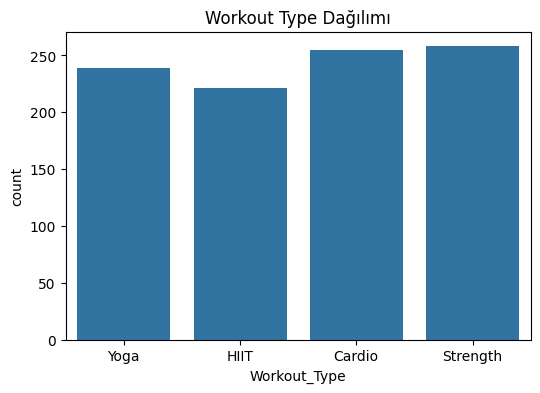

In [45]:
df["Workout_Type"].value_counts()
plt.figure(figsize=(6,4))
sns.countplot(x=df["Workout_Type"])
plt.title("Workout Type Dağılımı")
plt.show()


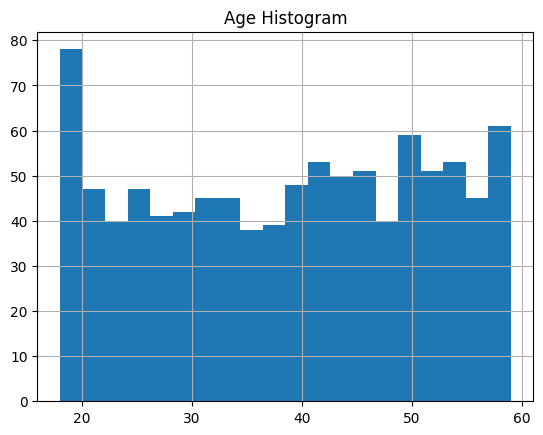

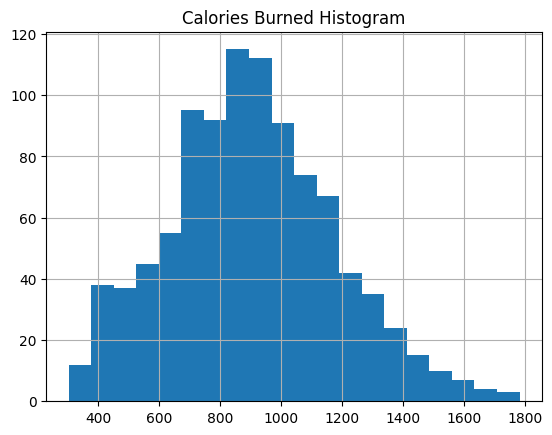

In [46]:
# Yaş ve Yakılan Kalori Dağılımı
df["Age"].hist(bins=20)
plt.title("Age Histogram")
plt.show()

df["Calories_Burned"].hist(bins=20)
plt.title("Calories Burned Histogram")
plt.show()


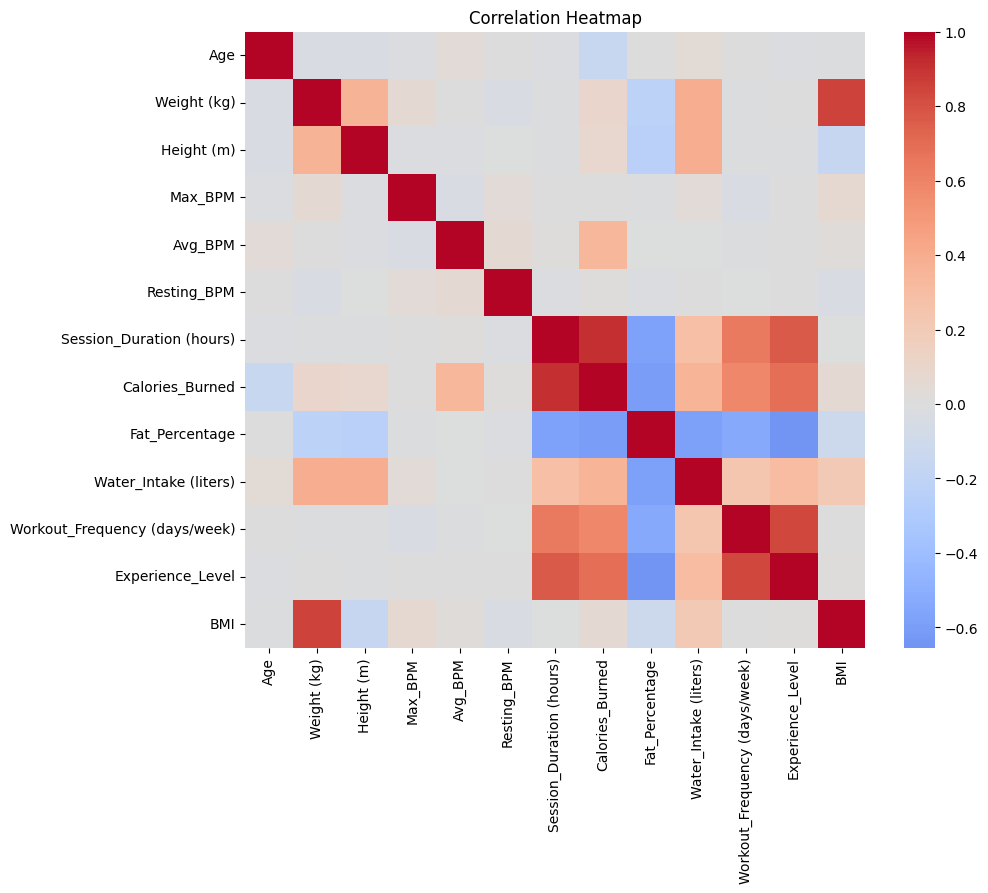

In [47]:
#CORRELATION HEATMAP
plt.figure(figsize=(10,8))
corr = df.select_dtypes(include=np.number).corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()


In [48]:
#FEATURE ENGINEERING

df["HR_per_minute"] = df["Avg_BPM"] / df["Session_Duration (hours)"]
df["Calories_per_kg"] = df["Calories_Burned"] / df["Weight (kg)"]
df["HRR"] = df["Max_BPM"] - df["Resting_BPM"]
# Label Encoding
le = LabelEncoder()
df["Workout_Type"] = le.fit_transform(df["Workout_Type"])

In [49]:
#TEST-TRAIN SPLIT
X = df.drop("Workout_Type", axis=1)
y = df["Workout_Type"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)#%20-80 train-test split

In [50]:
# BASELINE MODEL (string-safe)

# Eğer X_train içinde kategorik (object) kolon varsa encode et
if X_train.select_dtypes(include="object").shape[1] > 0:
    X_train = pd.get_dummies(X_train, drop_first=True)
    X_test = pd.get_dummies(X_test, drop_first=True)
    
    # Train ve test kolonlarını hizala
    X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

rf_baseline = RandomForestClassifier(random_state=42)
rf_baseline.fit(X_train, y_train)

y_pred_base = rf_baseline.predict(X_test)
print("Baseline Accuracy:", accuracy_score(y_test, y_pred_base))


Baseline Accuracy: 0.2358974358974359


In [51]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}
grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("Best Parameters:", grid.best_params_)
#GRID SEARCH FOR HYPERPARAMETER TUNING

Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}


In [52]:
#CV
cv_scores = cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=5
)

print("CV Accuracy Mean:", cv_scores.mean())


CV Accuracy Mean: 0.27642679900744416


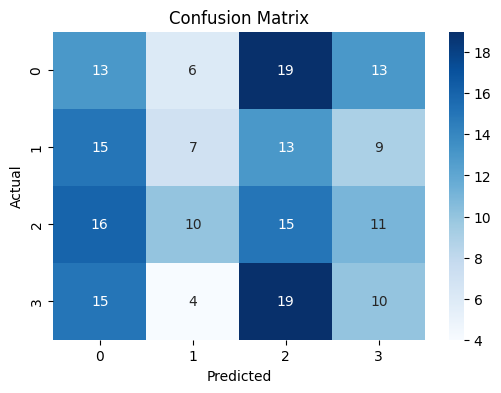

              precision    recall  f1-score   support

           0       0.22      0.25      0.24        51
           1       0.26      0.16      0.20        44
           2       0.23      0.29      0.25        52
           3       0.23      0.21      0.22        48

    accuracy                           0.23       195
   macro avg       0.23      0.23      0.23       195
weighted avg       0.23      0.23      0.23       195



In [53]:
#CONFUSION MATRIX AND CLASSIFICATION REPORT
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print(classification_report(y_test, y_pred))

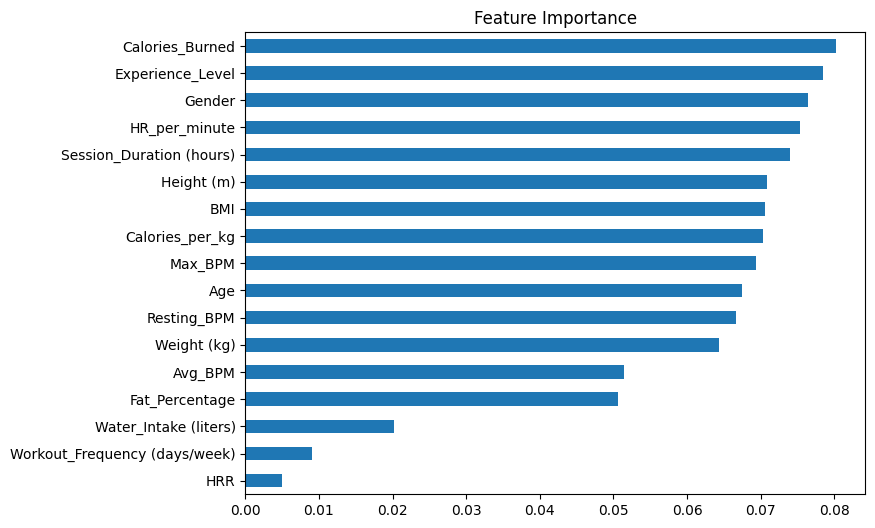

In [54]:
#FEATURE IMPORTANCE
importances = best_model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns)
feat_imp.sort_values().plot(kind="barh", figsize=(8,6))
plt.title("Feature Importance")
plt.show()


In [55]:
# === FULL DATA ENCODING ===

X_full = df.drop("Workout_Type", axis=1)
y = df["Workout_Type"]

X_full = pd.get_dummies(X_full, drop_first=True)


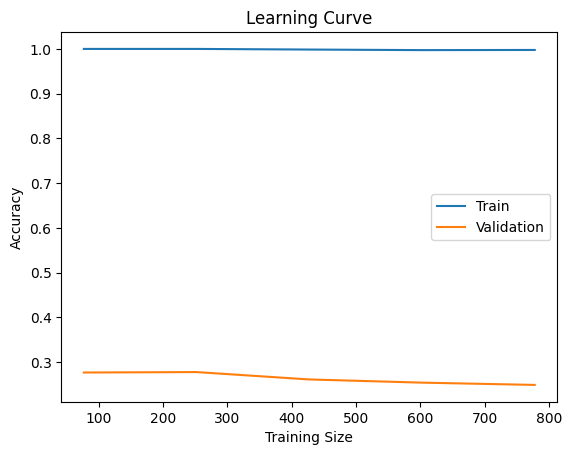

In [56]:
# Learning Curve (string-safe)

train_sizes, train_scores, test_scores = learning_curve(
    best_model,
    X_full,
    y,
    cv=5,
    n_jobs=-1,
    scoring="accuracy"
)

plt.plot(train_sizes, train_scores.mean(axis=1), label="Train")
plt.plot(train_sizes, test_scores.mean(axis=1), label="Validation")
plt.legend()
plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.show()


## Final Conclusions

- Random Forest modeli Workout_Type sınıflandırmasında başarılı olmuştur.
- Feature engineering performansı artırmıştır.
- HRR ve kalori temelli değişkenler en önemli özelliklerdir.
- Model aşırı overfitting göstermemektedir.
